In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from netCDF4 import Dataset

import matplotlib.image as mpimg
from matplotlib import cm
import matplotlib.animation as ani
from scipy.integrate import odeint
import pandas as pd

from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import pearsonr

import seaborn as sns
import copy

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
def calculate_error(df_predictions, do18):  
    df_error = pd.DataFrame(columns=["mae"])
    for sample in range(len(df_predictions)):
        df_error.loc[sample, "mae"] = mean_absolute_error(do18.loc[sample].values, df_predictions.loc[sample].values)
    return np.mean(df_error["mae"].values)

In [3]:
isotopes = Dataset('climatology/xnapa_isotopes.nc', "a")
precipitation = Dataset('climatology/xnapa_precip.nc', "a")
surface_temperature = Dataset('climatology/xnapa_temp.nc', "a")

In [4]:
lat = isotopes.variables["latitude"][:].data[1:-1]
long = isotopes.variables["longitude"][:].data
t = isotopes.variables["t"][:].data

trash = [626, 0]

In [5]:
do18 = []
precip = []
temp = []
for i in range(len(t)):
    do18.append(isotopes.variables["dO18"][i][0].data[1:-1].reshape(71*96))
    precip.append(precipitation.variables["precip"][i][0].data[1:-1].reshape(71*96))
    temp.append(surface_temperature.variables["temp_1"][i][0].data[1:-1].reshape(71*96))
    
do18 = pd.DataFrame(np.delete(np.delete(np.asarray(do18), 0, 0), 626, 0)[:1000])
precip = pd.DataFrame(np.delete(np.delete(np.asarray(precip), 0, 0), 626, 0)[:1000])
temp = pd.DataFrame(np.delete(np.delete(np.asarray(temp), 0, 0), 626, 0)[:1000])

In [21]:
scaler_temp = StandardScaler()
scaler_precip = StandardScaler()
scaler_do18 = StandardScaler()
df_temp = pd.DataFrame(scaler_temp.fit_transform(temp))
df_precip = pd.DataFrame(scaler_precip.fit_transform(precip))
df_do18 = pd.DataFrame(scaler_do18.fit_transform(do18))

In [22]:
n_temp = 900
n_precip = 900
n_y = 900

In [23]:
pca_temp = PCA(n_components=n_temp)
pca_precip = PCA(n_components=n_precip)
pca_do18 = PCA(n_components=n_y)

In [24]:
pc_do18 = pd.DataFrame(pca_do18.fit_transform(df_do18))
pc_temp = pd.DataFrame(pca_temp.fit_transform(df_temp))
pc_precip = pd.DataFrame(pca_precip.fit_transform(df_precip))

In [25]:
df_reverse_do18 = pd.DataFrame(scaler_do18.inverse_transform(pca_do18.inverse_transform(pc_do18)))

In [26]:
var_do18 = pca_do18.explained_variance_ratio_
var_temp = pca_temp.explained_variance_ratio_
var_precip = pca_precip.explained_variance_ratio_

In [27]:
calculate_error(do18, df_reverse_do18)

0.08174888639659116

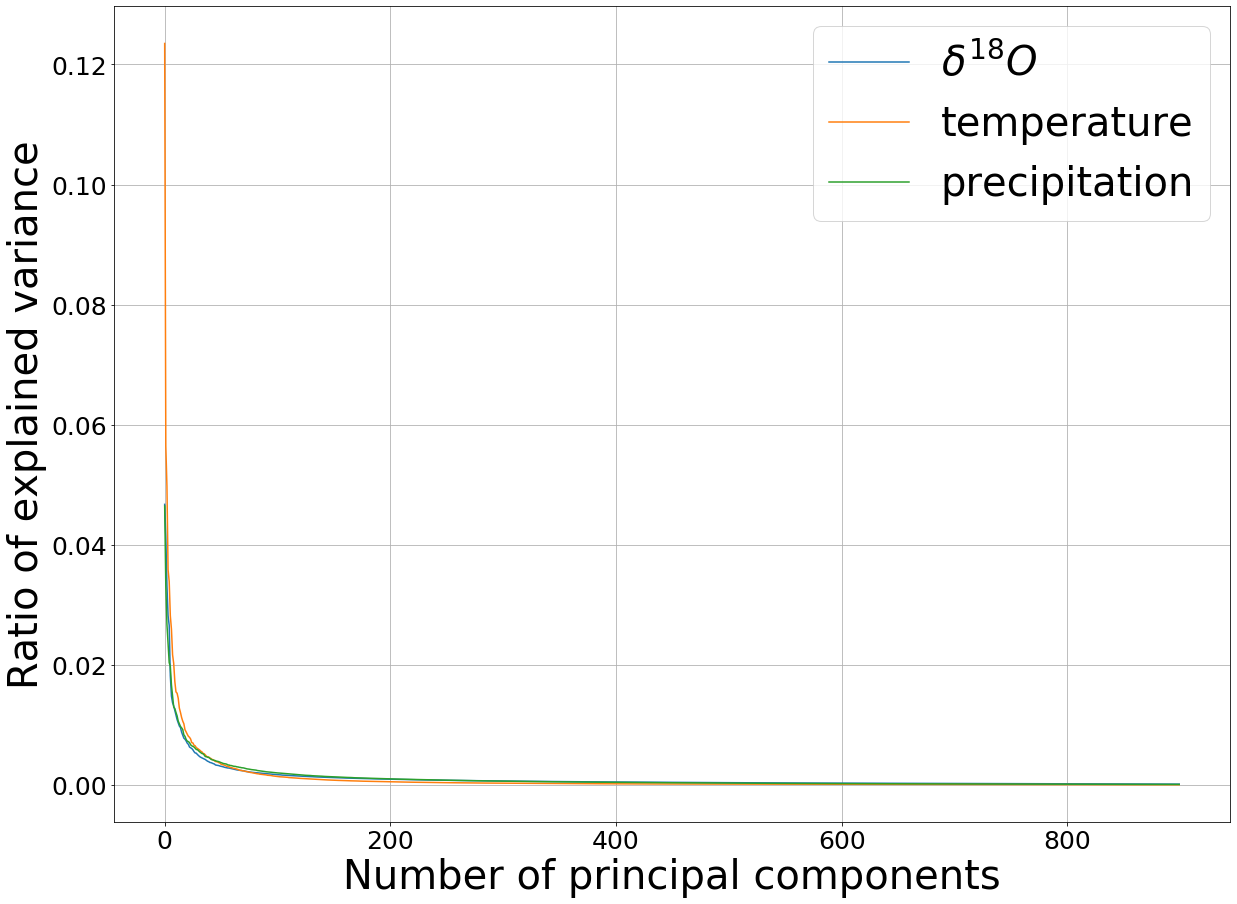

In [28]:
plt.figure(figsize=(20,15))

plt.plot(var_do18, label=r"$\delta^{18}O$")
plt.plot(var_temp, label="temperature")
plt.plot(var_precip, label="precipitation")

plt.legend(fontsize=40)
plt.grid()
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel("Number of principal components", fontsize=40)
plt.ylabel("Ratio of explained variance", fontsize=40)
#plt.savefig("figures/var.png")
plt.show()

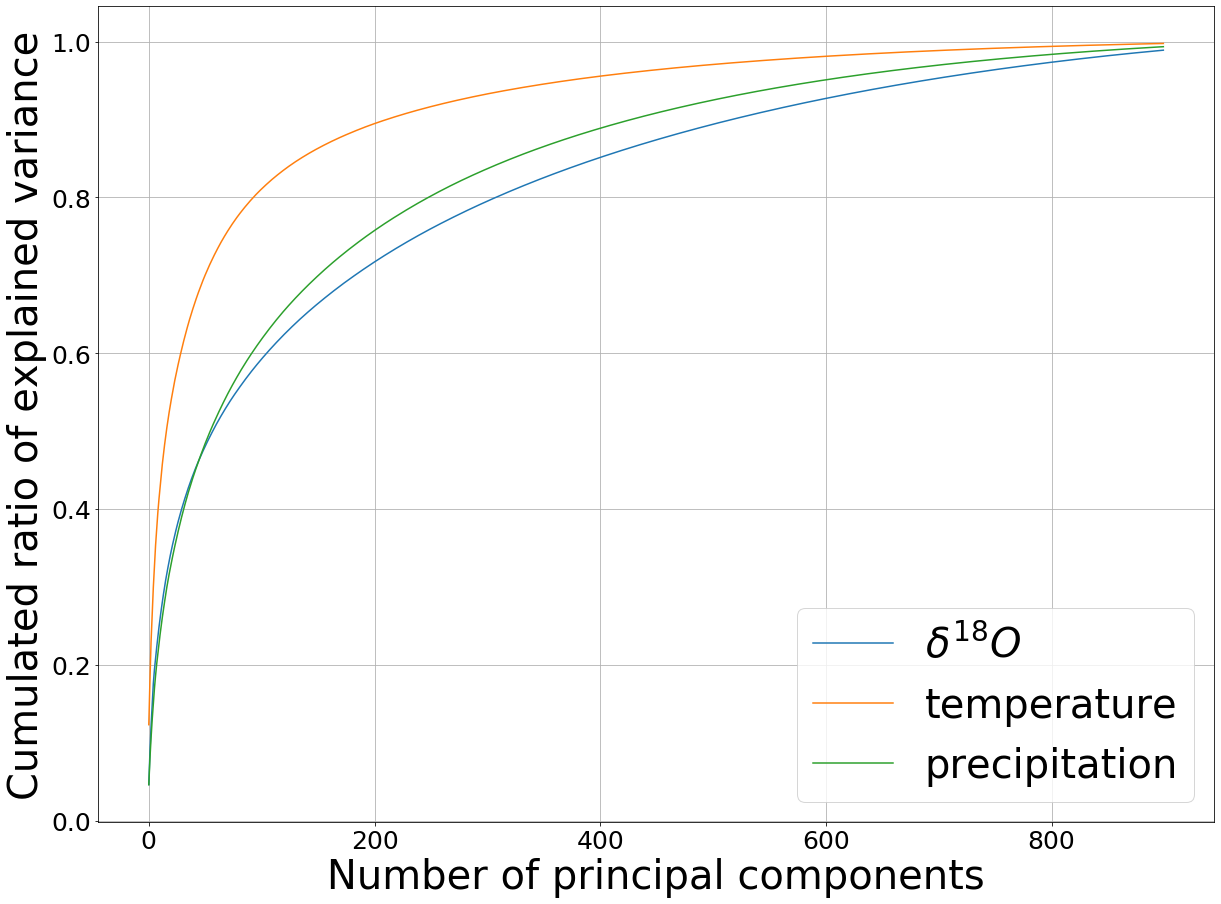

In [29]:
plt.figure(figsize=(20,15))
plt.plot(np.cumsum(var_do18), label=r"$\delta^{18}O$")
plt.plot(np.cumsum(var_temp), label="temperature")
plt.plot(np.cumsum(var_precip), label="precipitation")

plt.legend(fontsize=40)
plt.grid()
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel("Number of principal components", fontsize=40)
plt.ylabel("Cumulated ratio of explained variance", fontsize=40)
#plt.savefig("figures/cumratio.png")
plt.show()

In [12]:
iss = [1,2,4,6,8,10,13,16,20,25,30,35,40,50,60,80,100,130,160,200,240,280,330,380,420,450,500,550,600,650,720,780,850,900,950]
error = []
for i in iss:
    pca_do18 = PCA(n_components=i)
    pc_do18 = pd.DataFrame(pca_do18.fit_transform(df_do18))
    df_reverse_do18 = pd.DataFrame(scaler_do18.inverse_transform(pca_do18.inverse_transform(pc_do18)))
    error.append(mean_squared_error(df_reverse_do18, do18, squared=False))

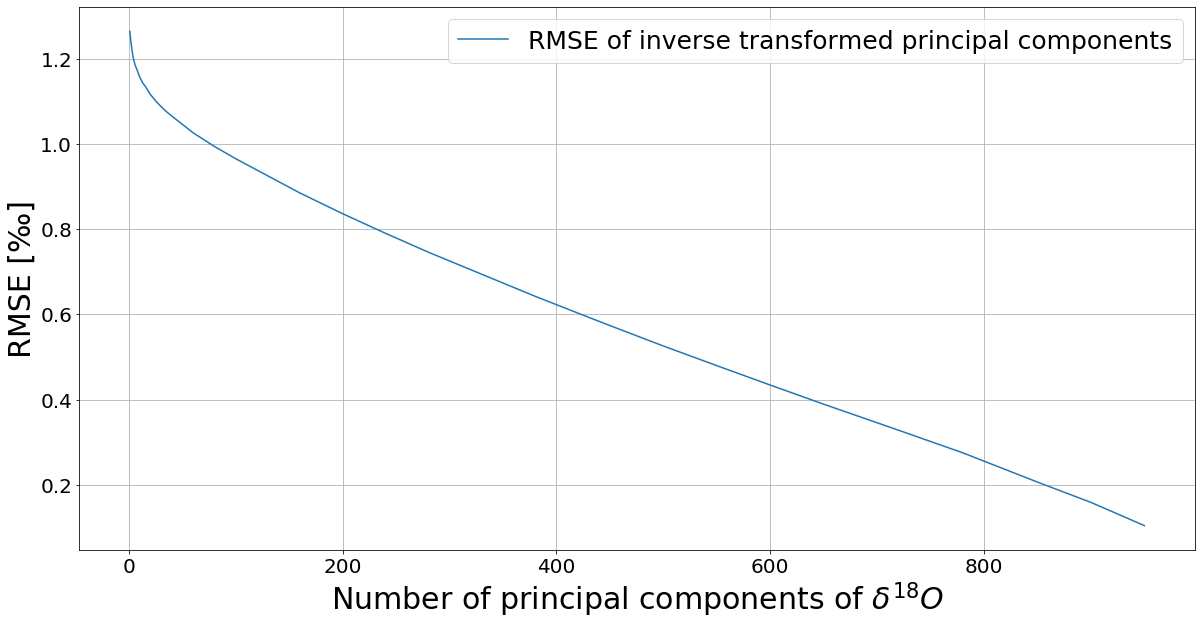

In [15]:
plt.figure(figsize=(20,10))
plt.plot(iss, error, label="RMSE of inverse transformed principal components")
plt.grid()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Number of principal components of $\delta^{18}O$", fontsize=30)
plt.ylabel(r"RMSE [‰]", fontsize=30)
plt.legend(fontsize=25)
plt.savefig("figures/inversedpc.png")
plt.show()

In [32]:
def plot_map(lat, long, para):
    amin = np.amin(para)
    amax = np.amax(para)
    matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
    fig = plt.figure()
    plt.pcolor(long, lat, para, cmap='seismic', vmin=max(abs(amin), abs(amax)), vmax=(-1)*max(abs(amin), abs(amax)))
    plt.tight_layout()
    cbar = plt.colorbar()

## Räumliche Darstellung der PC

In [30]:
n_y = 20

scaler_do18 = StandardScaler().fit(do18)
do18_scaler = scaler_do18.transform(do18)

pca_do18 = PCA(n_components=n_y).fit(do18_scaler)
do18_pc = pca_do18.transform(do18_scaler)

In [55]:
file = open("do18_components.txt", "w")
dump = "\n".join(pca_do18.components_.reshape(20*6816).astype(str).tolist())
file.write(dump)

2946108

In [37]:
pca_do18.components_.shape

(20, 6816)

In [57]:
pca_do18.components_

array([[ 0.00601114,  0.00600736,  0.00593302, ...,  0.01809793,
         0.01762202,  0.01738834],
       [-0.02739165, -0.02774544, -0.02777878, ...,  0.00840633,
         0.00732226,  0.00618328],
       [-0.04209049, -0.04189382, -0.04223034, ...,  0.00052016,
         0.00116923,  0.00173842],
       ...,
       [ 0.00083597,  0.00052845, -0.00015142, ...,  0.0036523 ,
         0.00354182,  0.0034921 ],
       [ 0.00628981,  0.00514005,  0.00517532, ..., -0.01186153,
        -0.01151833, -0.01184414],
       [-0.0076021 , -0.00589404, -0.00448986, ...,  0.01812959,
         0.01971395,  0.02043361]])

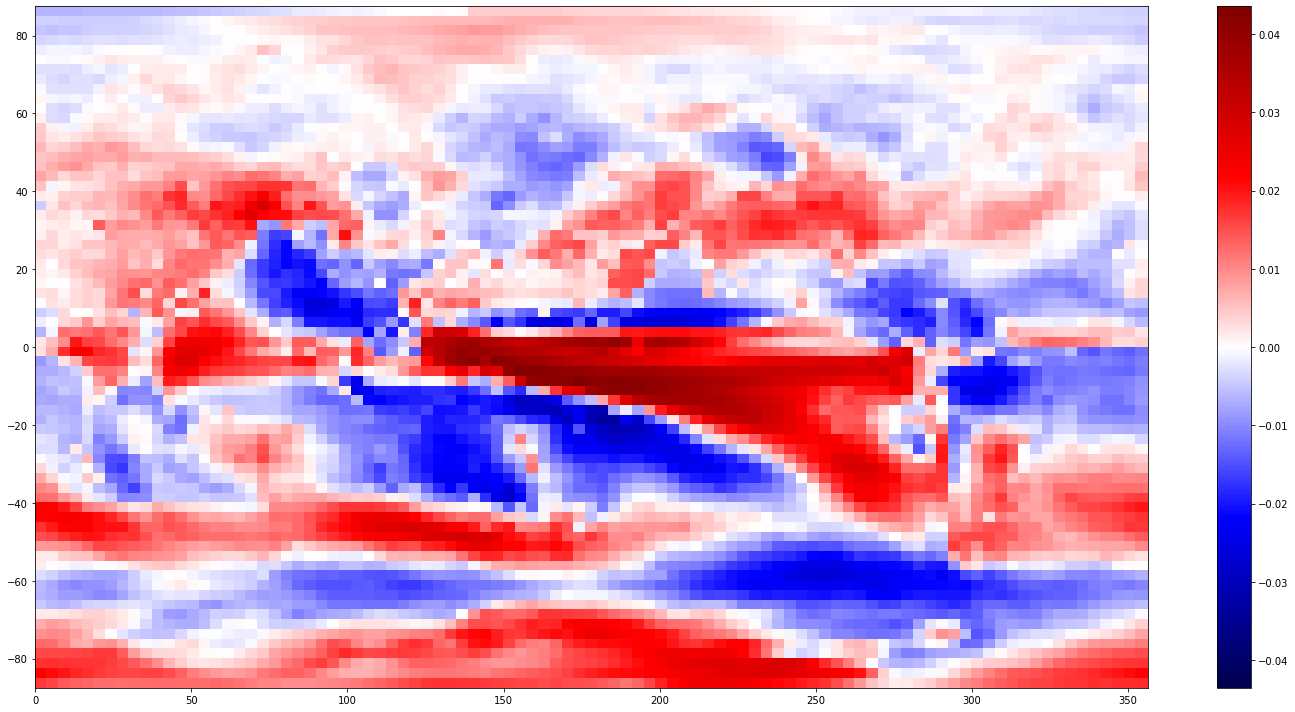

In [35]:
plot_map(lat, long, pca_precip.components_[0].reshape(71,96))